In [1]:
import os


import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
# import seaborn as sns # used for plot interactive graph. 
# from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
# from sklearn.preprocessing import StandardScaler # for normalization
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline # pipeline making
# from sklearn.model_selection import cross_val_score
# from sklearn.feature_selection import SelectFromModel
# from sklearn import metrics # for the check the error and accuracy of the model
# from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
# import keras
# from keras.layers import Dense
# from keras.models import Sequential
# from keras.utils import to_categorical
# from keras.optimizers import SGD 
# from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
# import itertools
# from keras.layers import LSTM
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.layers import Dropout


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Activation, Flatten

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
os.chdir('C:/Users/Olsen/Desktop/Masteroppgave/Code')

# new_model = tf.keras.models.load_model('forTransferL.h5')
# #model.layers[0].trainable = False
# #x = model.layers[10].output
# new_model.summary()

# Load the pre-trained model
pretrained_model = load_model('forTransferL.h5')

# Display the summary of the pre-trained model
pretrained_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                1260      
                                                                 
 dense_1 (Dense)             (None, 24)                864       
                                                                 
 activation (Activation)     (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 104       
                                                                 
 activation_2 (Activation)   (None, 8)                 

In [3]:
# date,timestamp,hrv,dfa,sport,feeling,rpe

def replace_feeling(value):
    if value >= 5:
        return 1
    else:
        return 2



# Function to load and preprocess data from a single file
def load_and_preprocess(file_path, session):
    # df = pd.read_csv(file_path, sep=',', 
    #              parse_dates={'dt' : ['date', 'timestamp']}, infer_datetime_format=True, 
    #              low_memory=False, na_values=['nan','?'], index_col='dt')
    df = pd.read_csv(file_path, sep=',')

    droping_list_all=[]

    df = df.drop(columns=['sport', 'date'])
    for j in range(0,len(df.columns)):
        if not df.iloc[:, j].notnull().all():
            droping_list_all.append(j)        
            #print(df.iloc[:,j].unique())
    
    # filling nan with mean in any columns

    for j in range(0,len(df.columns)):        
            df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
    # another sanity check to make sure that there are not more any nan
    df.isnull().sum()



    # Add a new column to the DataFrame
    session_numbers = [session]*len(df['hrv'])  # Example values for the new column
    df['session'] = session_numbers
    # df2 = pd.DataFrame({"session": [session]*len(df['hrv'])})
    # df = df.append(df2, ignore_index = True)

    # for f in df['feeling']:
    #     if f >= 5:
    #         df['feeling'][f] = 1
    #     else:
    #         df['feeling'][f] = 2
    # df.feeling[df.feeling == 9] = 2
    # df.feeling[df.feeling == 7] = 2
    # df.feeling[df.feeling == 5] = 2
    # df.feeling[df.feeling == 3] = 1
    #df.feeling[df.feeling == 1] = 1
    # Applying the function to the 'feeling' column
    df['feeling'] = df['feeling'].apply(lambda x: replace_feeling(x))

    # print(df.dtypes)
    # print(df.shape)
    # print(df.describe())


    X = df[['session','timestamp', 'hrv', 'dfa']]
    y = df['feeling']

    # scaler = MinMaxScaler()
    # X = scaler.fit_transform(X)
    return X, y

# Function to load and preprocess data from multiple files in a folder
def load_data_from_folder(folder_path):
    X_all, y_all = [], []

    session = 1

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            X, y = load_and_preprocess(file_path, session)
            X_all.append(X)
            y_all.append(y)
            session += 1


    X_all = np.vstack(X_all)
    y_all = np.concatenate(y_all)

    return X_all, y_all


In [4]:
# Specify the folder containing your CSV files
train_folder = "C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate2/csv_files"

# Load and preprocess data from multiple files in the folder
X_train, y_train = load_data_from_folder(train_folder)


# Specify the folder containing your CSV files
test_folder = "C:/Users/Olsen/Desktop/Masteroppgave/Data/fitfiler/candidate1/csv_files"

# Load and preprocess data from multiple files in the folder
X_test, y_test = load_data_from_folder(test_folder)

print(X_train)
# print(X_test)

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)



# Reshape input data for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)

[[1.00000000e+00 0.00000000e+00 1.03520000e+02 1.82174146e+00]
 [1.00000000e+00 1.00000000e+00 1.03860000e+02 1.75032626e+00]
 [1.00000000e+00 2.00000000e+00 1.04190000e+02 1.83079917e+00]
 ...
 [1.77000000e+02 4.62700000e+03 1.15340000e+02 1.24677653e+00]
 [1.77000000e+02 4.62800000e+03 1.15030000e+02 1.24677653e+00]
 [1.77000000e+02 4.62900000e+03 1.14740000e+02 1.24677653e+00]]
(852707, 1, 4)


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten

# Load the pre-trained model
pretrained_model = load_model('forTransferL.h5')

# Display the summary of the pre-trained model
pretrained_model.summary()

# Create a new model for transfer learning
transfer_model = Sequential()

# Add a Flatten layer to reshape the input
transfer_model.add(Flatten(input_shape=(1, 4), name='flatten_input'))

# Iterate through the pre-trained model layers and add corresponding layers to the transfer model
for layer in pretrained_model.layers[:-1]:
    if isinstance(layer, Dense):
        # Explicitly set the input shape for Dense layers
        transfer_model.add(Dense(layer.units, activation=layer.activation, input_shape=(4,), name=f'transfer_layer_{len(transfer_model.layers)-1}'))
    else:
        transfer_model.add(layer)

# Add a new output layer with the correct number of units for your specific problem
transfer_model.add(Dense(1, activation='sigmoid', name='output_layer'))  # Modify activation based on your problem

# Compile the transfer model
transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the transfer model
transfer_model.summary()

# Assuming your training data is stored in X_train and labels in y_train
# Make sure to adjust the parameters in fit() according to your requirements
transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the transfer model for future use
transfer_model.save('transfer_model.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                1260      
                                                                 
 dense_1 (Dense)             (None, 24)                864       
                                                                 
 activation (Activation)     (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 104       
                                                                 
 activation_2 (Activation)   (None, 8)                 0

c:\Users\Olsen\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Create a new model for transfer learning
transfer_model = Sequential()

# Add a Flatten layer to reshape the input
transfer_model.add(Flatten(input_shape=(1, 4)))


# Add layers to the transfer model by iterating through the pre-trained model layers
for layer in pretrained_model.layers[:-1]:
    # Add a layer with the same configuration, excluding the input shape
    transfer_model.add(layer.__class__.from_config(layer.get_config()))

# Add a new output layer with the correct number of units for your specific problem
transfer_model.add(Dense(1, activation='sigmoid'))  # Modify activation based on your problem


# Compile the transfer model
transfer_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the summary of the transfer model
transfer_model.summary()

# Assuming your training data is stored in X_train and labels in y_train
# Make sure to adjust the parameters in fit() according to your requirements
transfer_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



In [19]:
test_loss, test_acc = transfer_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest loss: ', test_loss)
print('\nTest accuracy: ', test_acc)


18339/18339 - 31s - loss: nan - accuracy: 0.0000e+00 - 31s/epoch - 2ms/step

Test loss:  nan

Test accuracy:  0.0
18339/18339 [==============================] - 36s 2ms/step


c:\Users\Olsen\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.

In [ ]:


# Make predictions
probability_model = tf.keras.Sequential([transfer_model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)
# predictions = model.predict(X_test)
result = confusion_matrix(y_test, predictions , normalize='pred')
print(classification_report(y_test, predictions))


disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()


[1 1 1 ... 1 1 1]
Accuracy: 0.4742857434981613
Classification Report:
              precision    recall  f1-score   support

           1       0.39      0.65      0.49    224602
           2       0.63      0.36      0.46    362232

    accuracy                           0.47    586834
   macro avg       0.51      0.51      0.47    586834
weighted avg       0.54      0.47      0.47    586834

              precision    recall  f1-score   support

           1       0.39      0.65      0.49    224602
           2       0.63      0.36      0.46    362232

    accuracy                           0.47    586834
   macro avg       0.51      0.51      0.47    586834
weighted avg       0.54      0.47      0.47    586834



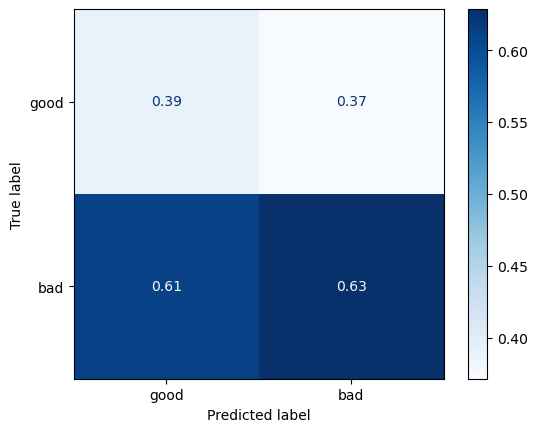

In [21]:


nsamples_train, nx_train, ny_train = X_train.shape
nsamples_test, nx_test, ny_test = X_test.shape
#print(nsamples, nx, ny)
X2_train = X_train.reshape((nsamples_train,nx_train*ny_train))
X2_test = X_test.reshape((nsamples_test,nx_test*ny_test))


rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=1, random_state=42)
rf_classifier.fit(X2_train, y_train)
y_pred = rf_classifier.predict(X2_test)

print(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

result = confusion_matrix(y_test, y_pred , normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest loss: ', test_loss)
print('\nTest accuracy: ', test_acc)


In [ ]:
# Make predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test)
# predictions = model.predict(X_test)
result = confusion_matrix(y_test, predictions , normalize='pred')
print(classification_report(y_test, predictions))


disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
nsamples_train, nx_train, ny_train = X_train.shape
nsamples_test, nx_test, ny_test = X_test.shape
#print(nsamples, nx, ny)
X2_train = X_train.reshape((nsamples_train,nx_train*ny_train))
X2_test = X_test.reshape((nsamples_test,nx_test*ny_test))

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=1, random_state=42)
rf_classifier.fit(X2_train, y_train)
y_pred = rf_classifier.predict(X2_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

result = confusion_matrix(y_test, y_pred , normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X2_train, y_train)
y_pred = rf_classifier.predict(X2_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred , normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=1000)
knn_classifier.fit(X2_train, y_train)
y_pred = rf_classifier.predict(X2_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred , normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X2_train, y_train)
y_pred = rf_classifier.predict(X2_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


result = confusion_matrix(y_test, y_pred , normalize='pred')
print(classification_report(y_test, y_pred))

disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['good','bad'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# model.save('forTransferL.h5')